<a href="https://colab.research.google.com/github/MarcLefevreFr/OpenClassrooms/blob/master/P6/P6_TL_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfert Learning_01**

### **Préliminaires**<br>**Import :**<br>- google drive<br>- données<br>- bibliothèques python

In [2]:
# instal google drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# récupe des zip d'images et extractions
import shutil
import os
import zipfile
from time import time

start = time()
cwd = os.getcwd()

shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "test.zip"), cwd)
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "train.zip"), cwd)

# données "low" = image originales mais juste les 30 première classes
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "test_light.zip"), cwd)
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "train_light.zip"), cwd)



with zipfile.ZipFile(cwd + "/test.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/train.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/test_light.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/train_light.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

print(f"Import & extraction des data : {time()-start:.0f} secondes.")

Import & extraction des data : 79 secondes.


In [4]:
# vérif
import os
# chemin des répertoires contenant les photos
PATH_TRAIN = "train"
PATH_TRAIN_l = "train_light"
PATH_TEST = "test"
PATH_TEST_l = "test_light"

len(os.listdir(PATH_TRAIN)), len(os.listdir(PATH_TEST)), len(os.listdir(PATH_TRAIN_l)), len(os.listdir(PATH_TEST_l))

(120, 120, 30, 30)

In [82]:
# Import python
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import PIL.ImageOps as ops
import os
import pickle
import random as rd
from time import time

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Conv2D, MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [6]:
def modelize(model, nb_epochs, train_gen, val_gen, train_steps, val_steps, mod_name, opti = "adam", verbose = 0):

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = opti,
                  metrics = ['accuracy'])

    start = time()

    history = model.fit(train_gen,
                        steps_per_epoch = train_steps,
                        epochs = nb_epochs,
                        validation_data = val_gen,
                        validation_steps = val_steps,
                        verbose = verbose)
    
    model.save_weights("drive/MyDrive/P6/Data/models/" + mod_name + ".h5")
    pickle.dump(history.history, open("drive/MyDrive/P6/Data/models/" + mod_name + "_hist.pickle", "wb" ))

    fig = plt.figure(figsize = (10,4))

    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    
    plt.plot(range(1, nb_epochs+1), train_acc, 'b', label='Train acc', color = "red")
    plt.plot(range(1, nb_epochs+1), val_acc, 'b', label='Validation acc', color = "blue")
    plt.title('Train & validation accuracies - ' + mod_name)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    print(f"Temps d'entrainements pour {nb_epochs} epochs : {time()-start:.0f} secondes.")
    print(f"Meilleure train_acc = {np.max(train_acc):.2f}, meilleure val_acc = {np.max(val_acc):.2f}")
    print()

    plt.show()

def create_generator(batch, train_folder, size = (100, 100)):

    generators = []

    train_datagen = ImageDataGenerator(rescale = 1./255#, # normalisation
                                    #rotation_range = 15,
                                    #horizontal_flip=True,
                                    #validation_split = 0.2
                                    )

    val_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 10,
                                    zoom_range = 0.1,
                                    fill_mode = "reflect"
                                    )

    train_gen = train_datagen.flow_from_directory(train_folder,
                                                target_size = size,
                                                batch_size = batch,
                                                class_mode = "categorical",
                                                seed = SEED,
                                                interpolation = "nearest"
                                                )

    val_gen = val_datagen.flow_from_directory(train_folder,
                                            target_size = size,
                                            batch_size = batch,
                                            class_mode = "categorical",
                                            seed = SEED,
                                            interpolation = "nearest"
                                            )
    
    return train_gen, val_gen


def create_test_generators(batch, test_folder, size = (100, 100)):

    # générateur d'images test, juste la normalisation
    test_datagen = ImageDataGenerator(rescale = 1./255)

    test_gen = train_datagen.flow_from_directory(test_folder,
                                                target_size = size,
                                                batch_size = batch,
                                                class_mode = "categorical",
                                                seed = SEED,
                                                interpolation = "nearest"
                                                )
    
    return test_gen

    # RECUP DU DICO DES CLASSES :
    # ---> mon_generator.class_indices

## **Transfert**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

In [11]:
# import vgg16 sans les couches denses
model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))

In [12]:
model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

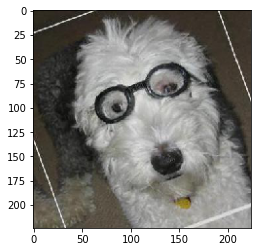

In [20]:
# SAMPLE KERAS

# img_path = 'elephant.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)


# on passe une image dans le réseau
path ="train" + "/" + os.listdir("train")[0] + "/" + os.listdir("train" + "/" +os.listdir("train")[0])[0]

img = image.load_img(path, target_size=(224, 224))

plt.imshow(img)

In [21]:
# transformation en array
x = image.img_to_array(img)
x.shape

(224, 224, 3)

In [22]:
# on rajoute une dims, comme si l'image était dans un batch de une image
x = np.expand_dims(x, axis=0)
x.shape

(1, 224, 224, 3)

In [23]:
# preprocessing propre à vgg 16... change pas les dims mais les valeurs...
x = preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [24]:
# prediction avec VGG
feat = model_VGG16.predict(x)

In [25]:
# il en ressort l'output de VGG, cad les 512 feat-maps au format 11*11
feat.shape

(1, 7, 7, 512)

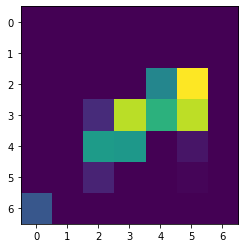

In [26]:
# affichage de la featmap[x]
plt.imshow(feat[0, :, :, 225])

## **Transfert Model-1**

In [36]:
# import vgg16 sans les couches denses
model_VGG16 = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

# définition de la sortie du model convo
# on zappe la dernière couche de pooling qui rendrait des images trop petites

for layer in model_VGG16.layers :
    layer.trainable = False

In [37]:
# partie dense
# entrée
x = model_VGG16.layers[-1].output
# applatissement
x = Flatten()(x)
# couche Dense 120 sortie directe
preds = Dense(120, activation = "softmax")(x)

In [38]:
# Def du modèle totale
mod_vgg16 = Model(inputs = model_VGG16.input, outputs = preds)
mod_vgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [39]:
BATCH = 32
SEED = 47
NB_TRAIN = 74137 # nb original
#NB_TRAIN_light = 4917 # nb original

TRAIN_STEPS = NB_TRAIN // BATCH
#TRAIN_STEPS_light = NB_TRAIN_light // BATCH

VAL_STEPS = TRAIN_STEPS // 5
#VAL_STEPS_light = TRAIN_STEPS_light // 5

print(TRAIN_STEPS, VAL_STEPS)

2316 463


In [40]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224))

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.


Epoch 1/10
2316/2316 [==============================] - 428s 185ms/step - loss: 4.6888 - accuracy: 0.2197 - val_loss: 1.9524 - val_accuracy: 0.5790
Epoch 2/10
2316/2316 [==============================] - 420s 181ms/step - loss: 1.3341 - accuracy: 0.6831 - val_loss: 1.4297 - val_accuracy: 0.6792
Epoch 3/10
2316/2316 [==============================] - 421s 182ms/step - loss: 0.8449 - accuracy: 0.7918 - val_loss: 1.3870 - val_accuracy: 0.7040
Epoch 4/10
2316/2316 [==============================] - 419s 181ms/step - loss: 0.6618 - accuracy: 0.8405 - val_loss: 1.2876 - val_accuracy: 0.7376
Epoch 5/10
2316/2316 [==============================] - 410s 177ms/step - loss: 0.5517 - accuracy: 0.8679 - val_loss: 1.1564 - val_accuracy: 0.7754
Epoch 6/10
2316/2316 [==============================] - 408s 176ms/step - loss: 0.4638 - accuracy: 0.8918 - val_loss: 1.0934 - val_accuracy: 0.7913
Epoch 7/10
2316/2316 [==============================] - 401s 173ms/step - loss: 0.4084 - accuracy: 0.9073 - val_

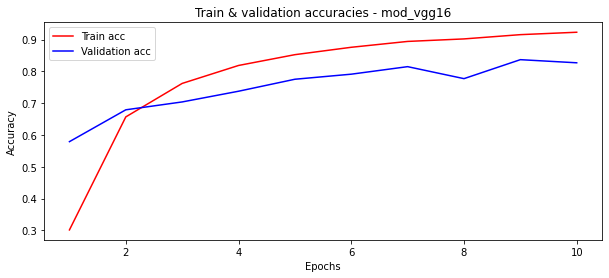

In [41]:
modelize(mod_vgg16, 10, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_vgg16", "adam", 1)

## **Transfert Model-2**<br>
GlobalMaxPool

In [47]:
# import vgg16 sans les couches denses
model_VGG16_2 = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

# définition de la sortie du model convo
# on zappe la dernière couche de pooling qui rendrait des images trop petites

for layer in model_VGG16_2.layers :
    layer.trainable = False

In [48]:
# partie dense
# entrée
x = model_VGG16_2.output
# applatissement
x = GlobalMaxPool2D()(x)
# dense 120 avec RelU
#x = Dense(120, activation = "relu")(x)
# dropout
# x = Dropout(0.1)(x)
# couche Dense 120 sortie
preds = Dense(120, activation = "softmax")(x)

In [49]:
mod_VGG16_2 = Model(inputs = model_VGG16_2.input, outputs = preds)
mod_VGG16_2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/10
2316/2316 [==============================] - 406s 175ms/step - loss: 3.4349 - accuracy: 0.2150 - val_loss: 2.7728 - val_accuracy: 0.3306
Epoch 2/10
2316/2316 [==============================] - 395s 170ms/step - loss: 2.5030 - accuracy: 0.3884 - val_loss: 2.4611 - val_accuracy: 0.3869
Epoch 3/10
2316/2316 [==============================] - 400s 173ms/step - loss: 2.2050 - accuracy: 0.4471 - val_loss: 2.2656 - val_accuracy: 0.4270
Epoch 4/10
2316/2316 [==============================] - 407s 176ms/step - loss: 2.0247 - accuracy: 0.4836 - val_loss: 2.1520 - val_accuracy: 0.4540
Epoch 5/10
2316/2316 [==============================] - 404s 174ms/step - loss: 1.9072 - accuracy: 0.5096 - val_loss: 2.1179 - val_accuracy: 0.4549
Epoch 6/10
2316/2316 [==============================] - 401s 173ms/step - loss: 1.8272 - accuracy: 0.5254 - val_loss: 2.0513 - val_accuracy: 0.4654
Epoch 7/10
2316/2316 [

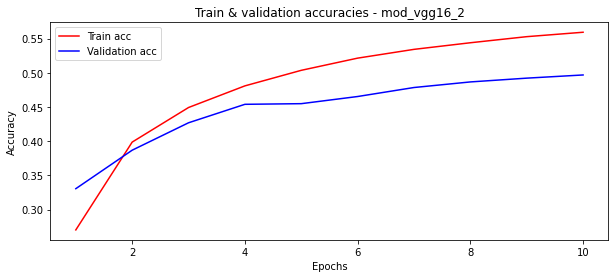

In [51]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224))
modelize(mod_VGG16_2, 10, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_vgg16_2", "adam", 1)

In [ ]:
# Moins bon, on va essayer avec l'averagepooling...

## **Transfert Model-3**<br>
GlobalAvPool

In [52]:
# import vgg16 sans les couches denses
model_VGG16_3 = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

# définition de la sortie du model convo
# on zappe la dernière couche de pooling qui rendrait des images trop petites

for layer in model_VGG16_3.layers :
    layer.trainable = False

In [55]:
# partie dense
# entrée
x = model_VGG16_3.output
# applatissement
x = GlobalAveragePooling2D()(x)
# dense 120 avec RelU
#x = Dense(120, activation = "relu")(x)
# dropout
# x = Dropout(0.1)(x)
# couche Dense 120 sortie
preds = Dense(120, activation = "softmax")(x)

In [56]:
mod_VGG16_3 = Model(inputs = model_VGG16_3.input, outputs = preds)
mod_VGG16_3.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5
2316/2316 [==============================] - 399s 172ms/step - loss: 4.3828 - accuracy: 0.0856 - val_loss: 3.6589 - val_accuracy: 0.2135
Epoch 2/5
2316/2316 [==============================] - 401s 173ms/step - loss: 3.4681 - accuracy: 0.2489 - val_loss: 3.2581 - val_accuracy: 0.2670
Epoch 3/5
2316/2316 [==============================] - 400s 173ms/step - loss: 3.0802 - accuracy: 0.3128 - val_loss: 3.0163 - val_accuracy: 0.3145
Epoch 4/5
2316/2316 [==============================] - 399s 172ms/step - loss: 2.8316 - accuracy: 0.3568 - val_loss: 2.8452 - val_accuracy: 0.3459
Epoch 5/5
2316/2316 [==============================] - 397s 171ms/step - loss: 2.6785 - accuracy: 0.3834 - val_loss: 2.7032 - val_accuracy: 0.3723
Temps d'entrainements pour 5 epochs : 1996 secondes.
Meilleure train_acc = 0.39, meilleure val_acc = 0.37



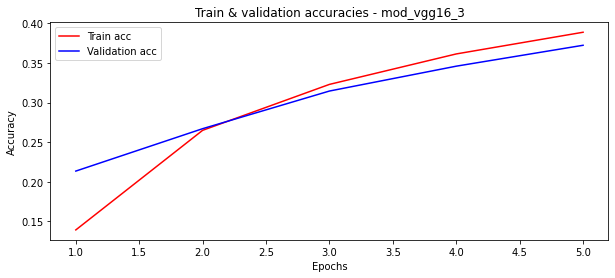

In [57]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224))
modelize(mod_VGG16_3, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_vgg16_3", "adam", 1)

In [ ]:
# encore moins bon

## **Transfert Model-3**<br>
2 couches denses

In [59]:
# import vgg16 sans les couches denses
model_VGG16_4 = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

# définition de la sortie du model convo
# on zappe la dernière couche de pooling qui rendrait des images trop petites

for layer in model_VGG16_4.layers :
    layer.trainable = False

In [62]:
# essai d'une autre syntaxe
mod_VGG16_4 = Sequential()
mod_VGG16_4.add(model_VGG16_4)
mod_VGG16_4.add(Flatten())
mod_VGG16_4.add(Dense(120, activation = "relu"))
mod_VGG16_4.add(Dense(120, activation = "softmax"))

In [63]:
mod_VGG16_4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               3010680   
_________________________________________________________________
dense_10 (Dense)             (None, 120)               14520     
Total params: 17,739,888
Trainable params: 3,025,200
Non-trainable params: 14,714,688
_________________________________________________________________


In [64]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224))
modelize(mod_VGG16_4, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_vgg16_4", "adam", 1)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5
1888/2316 [=======================>......] - ETA: 42s - loss: 4.8054 - accuracy: 0.0111

KeyboardInterrupt: ignored

## **InceptionResNetV2**<br>
avec images 200*200<br>les images doivent être entre 299*299 et 150*150.

In [75]:
# import InceptionResNetV2 sans les couches denses
model_IN_1 = InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (299,299,3))

In [76]:
for layer in model_IN_1.layers :
    layer.trainable = False

In [79]:
# partie dense
# entrée
x = model_IN_1.output
# applatissement
x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)
# dense 120 avec RelU
#x = Dense(120, activation = "relu")(x)
# dropout
# x = Dropout(0.1)(x)
# couche Dense 120 sortie
preds = Dense(120, activation = "softmax")(x)

mod_IN_1 = Model(inputs = model_IN_1.input, outputs = preds)
model_IN_1.output.shape

TensorShape([None, 8, 8, 1536])

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5
2316/2316 [==============================] - 595s 253ms/step - loss: 6.2637 - accuracy: 0.8164 - val_loss: 3.8148 - val_accuracy: 0.9166
Epoch 2/5
2316/2316 [==============================] - 583s 252ms/step - loss: 2.8386 - accuracy: 0.9375 - val_loss: 3.7344 - val_accuracy: 0.9308
Epoch 3/5
2316/2316 [==============================] - 584s 252ms/step - loss: 2.0176 - accuracy: 0.9553 - val_loss: 3.1393 - val_accuracy: 0.9465
Epoch 4/5
2316/2316 [==============================] - 575s 248ms/step - loss: 1.5970 - accuracy: 0.9682 - val_loss: 2.9409 - val_accuracy: 0.9542
Epoch 5/5
2316/2316 [==============================] - 571s 246ms/step - loss: 1.2328 - accuracy: 0.9748 - val_loss: 2.6446 - val_accuracy: 0.9613
Temps d'entrainements pour 5 epochs : 2911 secondes.
Meilleure train_acc = 0.97, meilleure val_acc = 0.96



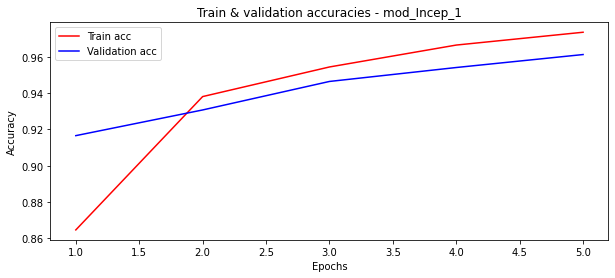

In [80]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (299, 299))
modelize(mod_IN_1, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_Incep_1", "adam", 1)

Epoch 1/5
2316/2316 [==============================] - 587s 249ms/step - loss: 1.2403 - accuracy: 0.9779 - val_loss: 2.5305 - val_accuracy: 0.9662
Epoch 2/5
2316/2316 [==============================] - 568s 245ms/step - loss: 1.0005 - accuracy: 0.9815 - val_loss: 3.3939 - val_accuracy: 0.9572
Epoch 3/5
2316/2316 [==============================] - 568s 245ms/step - loss: 1.0099 - accuracy: 0.9835 - val_loss: 2.3224 - val_accuracy: 0.9694
Epoch 4/5
2316/2316 [==============================] - 577s 249ms/step - loss: 0.7327 - accuracy: 0.9868 - val_loss: 2.4911 - val_accuracy: 0.9679
Epoch 5/5
2316/2316 [==============================] - 579s 250ms/step - loss: 0.8238 - accuracy: 0.9860 - val_loss: 3.0152 - val_accuracy: 0.9640
Temps d'entrainements pour 5 epochs : 2881 secondes.
Meilleure train_acc = 0.99, meilleure val_acc = 0.97



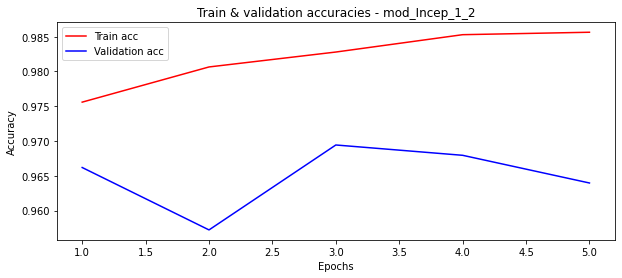

In [81]:
# Wow !
# On va entrainer 5 epochs supplé.
modelize(mod_IN_1, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_Incep_1_2", "adam", 1)

In [ ]:
overfit à partir de 5 + 3 epochs

## **EfficientNet30**<br>
On va essayer un modèle léger...<br>dim = 224*224

In [83]:
model_EFF30_1 = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

16711680/16705208 [==============================] - 0s 0us/step


In [84]:
for layer in model_EFF30_1.layers :
    layer.trainable = False

In [85]:
# partie dense
# entrée
x = model_IN_1.output
# applatissement
x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)
# dense 120 avec RelU
#x = Dense(120, activation = "relu")(x)
# dropout
# x = Dropout(0.1)(x)
# couche Dense 120 sortie
preds = Dense(120, activation = "softmax")(x)

mod_EFF30_1 = Model(inputs = model_IN_1.input, outputs = preds)
model_EFF30_1.output.shape

TensorShape([None, 7, 7, 1280])

In [86]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN, (224, 224))
modelize(mod_EFF30_1, 5, train_gen, val_gen,  TRAIN_STEPS, VAL_STEPS, "mod_EFF30_1", "adam", 1)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.
Epoch 1/5


InvalidArgumentError: ignored

In [87]:
model_EFF30_1.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
EfficientNetB0